<a href="https://colab.research.google.com/github/SergeiVKalinin/ACerS_AE_2024/blob/main/13_(r)vae_cards.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Principles and Applications of (invariant) Variational Autoencoders
- Tutorial by Sergei V. Kalinin (https://scholar.google.com/citations?user=-cuxoSQAAAAJ&hl=en), sergei2@utk.edu
- Based on the notebook by Mani Valetti (https://scholar.google.com/citations?hl=en&user=Jt7c5d4AAAAJ), valletisai.mani@gmail.com
- The full collection is available at https://github.com/saimani5/vae-tutorials
- Based on PyroVED by Maxim Ziatdiinov (https://scholar.google.com/citations?user=YnSdOoUAAAAJ
)  
- PyriVed library is available at https://github.com/ziatdinovmax/pyroVED/

*   This notebook takes you through the application of simple and rotationally invariant variational autoencoder (rVAE) on four different cards datasets and the results analysis.  
*   Each cards dataset if formed by applying a random rotation and shear to the images of the cards. The datasets differ in the limits used for picking the rotations and shear.
*   rVAE comprises of an additional latent dimension to the regular VAE, which explicitly captures the rotations involved in the image.
*   This angular latent dimension is learned in an unsupervised manner while trying to reconstuct the original image.
*   Like in VAE, this latent dimension is also regularized using a prior.  

In [1]:
# Installing Kornia and PyroVed
# Kornia is a library fo rimage augmentation that we will use to introduce known (ground truth) factors of variability in data
# PyroVED allows to buind VAEs that we will use to discover these (unknown to VAE) factors of variability

!pip install -q kornia git+https://github.com/ziatdinovmax/pyroVED@main

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 825.4/825.4 kB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 50.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 745.2/745.2 kB 47.2 MB/s eta 0:00:00


In [2]:
# Importing necessary packages

import pyroved as pv
import kornia as K

import cv2
from torchvision.utils import make_grid
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['axes.linewidth'] = 3

tt = torch.tensor

In [3]:
#@title Helper functions that apply afffine transformations to the dataset
rs = lambda x: cv2.resize(x, (64, 64), cv2.INTER_CUBIC)

def get_data():
    card1 = rs(cv2.imread("cards/card1.JPG", cv2.IMREAD_GRAYSCALE))
    card2 = rs(cv2.imread("cards/card2.JPG", cv2.IMREAD_GRAYSCALE))
    card3 = rs(cv2.imread("cards/card3.JPG", cv2.IMREAD_GRAYSCALE))
    card4 = rs(cv2.imread("cards/card4.JPG", cv2.IMREAD_GRAYSCALE))
    card1 = tt(1 - card1 / card1.max())
    card2 = tt(1 - card2 / card2.max())
    card3 = tt(1 - card3 / card3.max())
    card4 = tt(1 - card4 / card4.max())
    return card1, card2, card3, card4


import math
def transform_imgs(cards, **kwargs):
    np.random.seed(0)
    torch.manual_seed(0)

    a = kwargs.get("angle")
    t = kwargs.get("translation")
    s = (kwargs.get("shear"))
    if s is not None:
        s = math.radians(s)


    n_samples = kwargs.get("samples", 3000)
    n_samples_total = n_samples*4

    card1, card2, card3, card4 = cards[0], cards[1], cards[2], cards[3]

    card1 = card1[None, None].repeat_interleave(n_samples, dim = 0)
    card2 = card2[None, None].repeat_interleave(n_samples, dim = 0)
    card3 = card3[None, None].repeat_interleave(n_samples, dim = 0)
    card4 = card4[None, None].repeat_interleave(n_samples, dim = 0)

    cards_all = torch.cat((card1, card2, card3, card4), dim = 0)

    angles = tt(np.random.uniform(low = -a, high = a, size = [n_samples_total]))
    translations = tt(np.random.uniform(low = -t, high = t, size = [n_samples_total,1])).repeat_interleave(2, dim = 1)
    shears = tt(np.random.uniform(low = -s, high = s, size = [n_samples_total, 1])).repeat_interleave(2, dim = 1)

    transform = nn.Sequential(
        K.augmentation.CenterCrop((48, 48)),
        K.geometry.Affine(angle = angles, translation = translations,
                          shear = shears)
    )

    cards = transform(cards_all).squeeze().float()
    labels = torch.cat([torch.zeros(len(card1)), torch.ones(len(card2)), 2*torch.ones(len(card3)), 3*torch.ones(len(card4))])
    return cards, labels, angles, translations, shears


def plot_manifolds(model):
    fig, axes = plt.subplots(2, 2, figsize=(12, 12),
                            subplot_kw={'xticks':[], 'yticks':[]},
                            gridspec_kw=dict(hspace=0.1, wspace=0.05))
    for i, ax in enumerate(axes.flat):
        manifold = model.manifold2d(d=9, label=i, plot=False)
        grid = make_grid(manifold[:, None], nrow=9, pad_value=.5)
        ax.imshow(grid[0], cmap='viridis')
    plt.show()

In [4]:
# Downloading the cards dataset
!gdown -q https://drive.google.com/uc?id=1AyGHVflbIjzinkKBURHNVDx1wWg9JixB
!unzip -o -qq cards.zip

Here we make 4 different datasets using the above helper functions which are as follows:  
*  cards-i: low rotations (12 degrees) and low shear (1 degree)
*  cards-ii: low rotations (12 degrees) and high shear (20 degrees)
*  cards-iii: high rotations (120 degrees) and low shear (1 degree)
*  cards-iv: high rotations (120 degrees) and high shear (20 degrees)
Rotations, translation and shear (if added) will be the ground truth factors of variability (or traits) in data.

In [5]:
cards = get_data()
cards_all1, labels_all1, angles_all1, translations_all1, shears_all1 = transform_imgs(cards, angle = 12, translation = 0.1, shear = 1, samples = 300)   # cards-i
cards_all2, labels_all2, angles_all2, translations_all2, shears_all2 = transform_imgs(cards, angle = 12, translation = 0.1, shear = 20, samples = 300)   # cards-ii
cards_all3, labels_all3, angles_all3, translations_all3, shears_all3 = transform_imgs(cards, angle = 120, translation = 0.1, shear = 1, samples = 300)   # cards-iii
cards_all4, labels_all4, angles_all4, translations_all4, shears_all4 = transform_imgs(cards, angle = 120, translation = 0.1, shear = 20, samples = 300)   # cards-iv

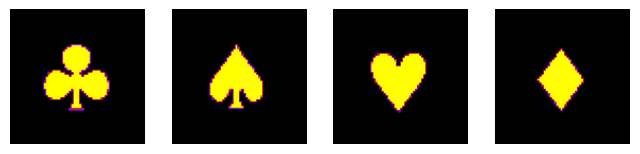

In [6]:
# Visualizing the cards before applying transformations
fig, ax = plt.subplots(ncols = 4, figsize = (8,2))
for i in range(4):
    ax[i].imshow(cards[i], cmap = 'gnuplot')
    ax[i].axis('off')

# Training


In [7]:
# First we initialize the train Loaders for all the datasets
# Trainloader allows us to feed the training data to the VAE in batches effctively avoiding using too much memory

# Note that None corresponds to adding a dummy channel dimension to the dataset
train_loader1 = pv.utils.init_dataloader(cards_all1[:, None], batch_size=50)   #cards-i
train_loader2 = pv.utils.init_dataloader(cards_all2[:, None], batch_size=50)   #cards-ii
train_loader3 = pv.utils.init_dataloader(cards_all3[:, None], batch_size=50)   #cards-iii
train_loader4 = pv.utils.init_dataloader(cards_all4[:, None], batch_size=50)   #cards-iv

In [8]:
# For convenience, let's choose one data set of four.
# Keep track of what factors of variability we introduced, and how storng they are
# Make sure that the chosen trian loader matches the selected ground truth labels

train_loader0 = train_loader4
cards_all0, labels_all0, angles_all0, translations_all0, shears_all0 = cards_all4, labels_all4, angles_all4, translations_all4, shears_all4

In [9]:
# Training the rVAE

in_dim = (48, 48)  # Input dimensions of the dataset i.e., shape of each card's image

# Initialize probabilistic VAE model ->
# (invariances=None: vanilla VAE
#  invariances=['r']: enforces rotational invariance
#  invariances=['t']: enforces translational invariance
#  invariances=['r', 't']: enforces invariance to rotations & translations
#  etc.)


rvae1 = pv.models.iVAE(in_dim, latent_dim=2,  # Number of latent dimensions other than the invariancies
                      hidden_dim_e = [256, 256], # corresponds to the number of neurons in the hidden layers of the encoder
                     hidden_dim_d = [256, 256],  # corresponds to the number of neurons in the hidden layers of the decoder
                     invariances= ['r'], seed=0)

# Initialize SVI trainer
trainer1 = pv.trainers.SVItrainer(rvae1)

# Train for n epochs:
for e in range(100):
    trainer1.step(train_loader0)
    trainer1.print_statistics()

Epoch: 1 Training loss: 1129.4703
Epoch: 2 Training loss: 993.3486
Epoch: 3 Training loss: 784.0943
Epoch: 4 Training loss: 605.6552
Epoch: 5 Training loss: 573.0746
Epoch: 6 Training loss: 452.8701
Epoch: 7 Training loss: 432.9195
Epoch: 8 Training loss: 423.5823
Epoch: 9 Training loss: 416.4330
Epoch: 10 Training loss: 423.7834
Epoch: 11 Training loss: 421.2763
Epoch: 12 Training loss: 411.1054
Epoch: 13 Training loss: 403.7939
Epoch: 14 Training loss: 404.9702
Epoch: 15 Training loss: 402.6258
Epoch: 16 Training loss: 401.0836
Epoch: 17 Training loss: 403.6907
Epoch: 18 Training loss: 398.1702
Epoch: 19 Training loss: 403.2886
Epoch: 20 Training loss: 402.9865
Epoch: 21 Training loss: 398.0944
Epoch: 22 Training loss: 391.4435
Epoch: 23 Training loss: 392.5315
Epoch: 24 Training loss: 391.0215
Epoch: 25 Training loss: 403.3209
Epoch: 26 Training loss: 397.0161
Epoch: 27 Training loss: 388.1187
Epoch: 28 Training loss: 386.5580
Epoch: 29 Training loss: 384.3470
Epoch: 30 Training los

# Vizualizing the results

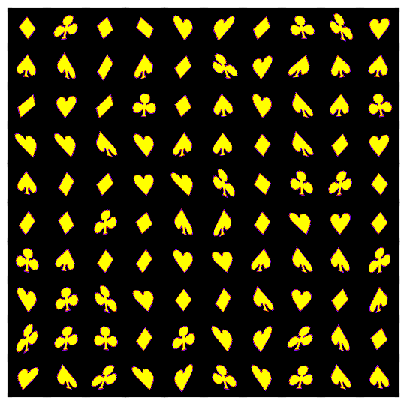

In [10]:
# First let's just visualize some randomly picked samples from the input dataset
# This gives us the idea of how the data looks like

np.random.seed(1)  # fix seed so that we get the same samples displayed at every run
fig, axes = plt.subplots(10, 10, figsize=(5, 5),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))

for ax in axes.flat:
    i = np.random.randint(len(cards_all0))
    ax.imshow(cards_all2[i], cmap='gnuplot', interpolation='nearest')

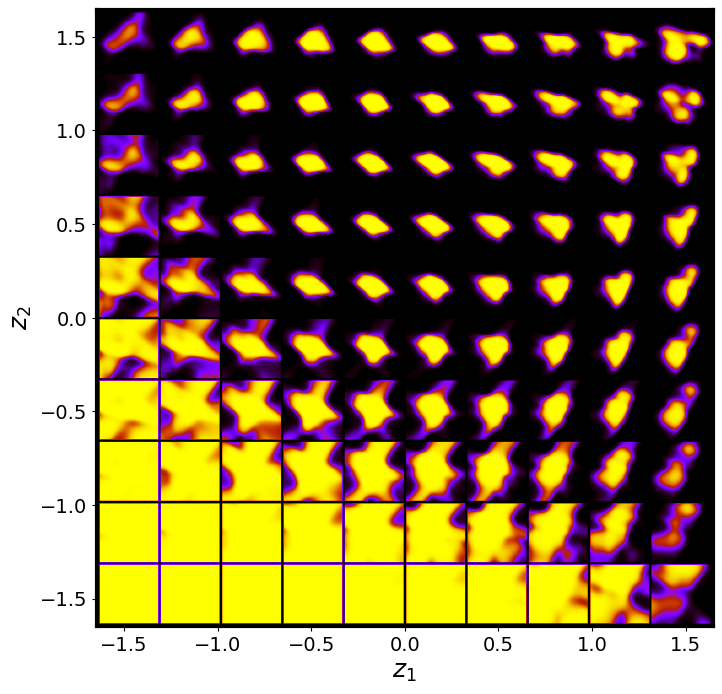

In [11]:
# Visualizing latent representations: decoded latent space
# The latent space is uniformly sampled in z1-z2 latent dimensions.
# These points are decoded back into the image space and are plotted in their corresponding latent space positions

rvae1.manifold2d(d = 10);   # d corresponds to the number of points sampled in each latent dimension; try changing it

Latent representation allows to explore the disentanglement of the factors of variability in the data. In principle, we can take each point in the latent space, decode image, and then plot some characteristic of the image such as strucutral similarity index (SSID) with one of the original hands, the rotation or shear, etc. This can show us how this characteristic is distributed across the full latent space, including the points that correspond to real objects (i.e. the part of latent distribution) and all other points. Thats actually what "generative model" means - we can decode objects from all parts of the latent space.

You can see example of this approach in:
- Figure 6 in https://arxiv.org/abs/2011.11869
- Figure 6 in https://arxiv.org/abs/2105.07125


Latent Distributions:  
- Input images are represented as points in the latent space using the encoder  
- TWe can use the ground-truth parameters to visualize their distribution within the latent space

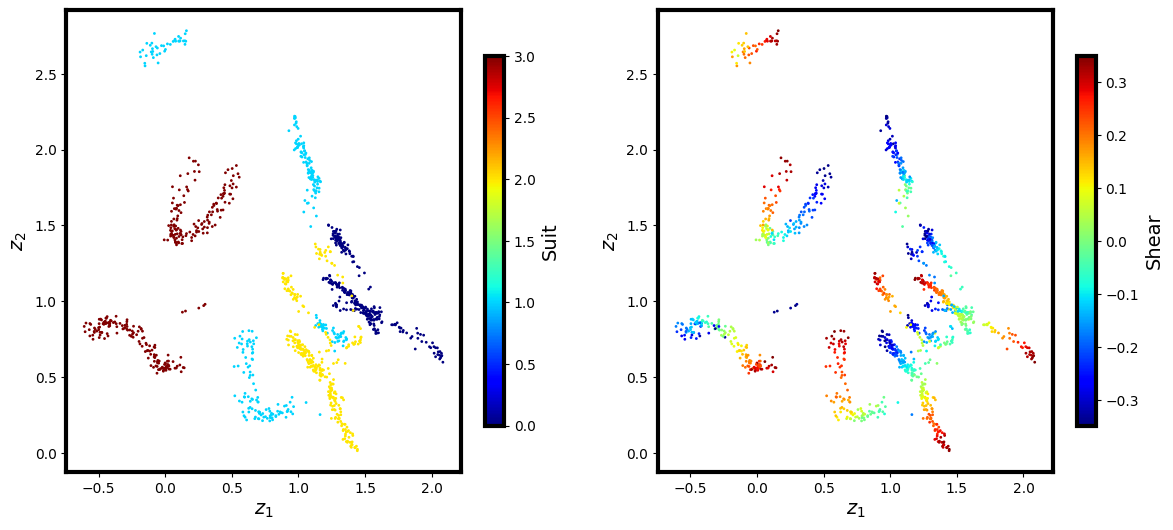

In [12]:
z_mean1, z_sd1 = rvae1.encode(cards_all0)   # Encoding the full input dataset

# z_mean1: mean of the latent space representation of the input dataset,
# z_sd1: standard deviation of the latent space representation of the input dataset,
# 0th column corresponds to angle and then the regular latent dimensions (First invariant dimensions and then regular latent dimensions)


# Latent distribution colored using the suit of each image
fig, ax = plt.subplots(1, 2, figsize =(14, 6))
im = ax[0].scatter(z_mean1[:,-1], z_mean1[:,-2], c=labels_all0, s=1, cmap='jet')
ax[0].set_xlabel("$z_1$", fontsize=14)
ax[0].set_ylabel("$z_2$", fontsize=14)
cbar = fig.colorbar(im, ax=ax[0], shrink=.8)
cbar.set_label("Suit", fontsize=14)
cbar.ax.tick_params(labelsize=10)

# Latent distribution colored using the ground truth shear applied on each image
im = ax[1].scatter(z_mean1[:,-1], z_mean1[:,-2], c=shears_all0[:,0], s=1, cmap='jet')
ax[1].set_xlabel("$z_1$", fontsize=14)
ax[1].set_ylabel("$z_2$", fontsize=14)
cbar = fig.colorbar(im, ax=ax[1], shrink=.8)
cbar.set_label("Shear", fontsize=14)
cbar.ax.tick_params(labelsize=10)

plt.show()

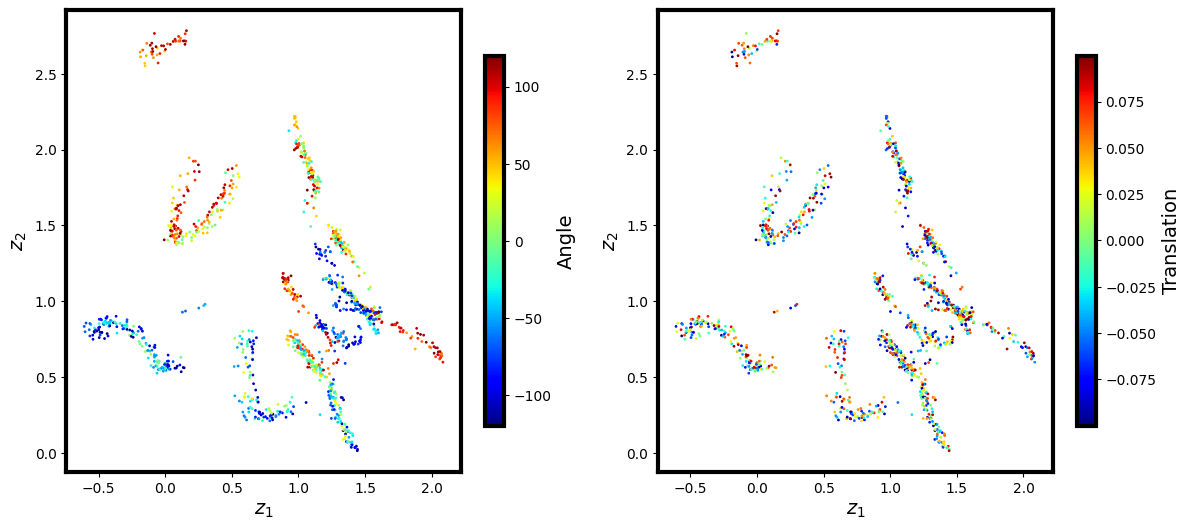

In [13]:
# Latent distribution colored using the angle of each image

fig, ax = plt.subplots(1, 2, figsize =(14, 6))
im = ax[0].scatter(z_mean1[:,-1], z_mean1[:,-2], c=angles_all0, s=1, cmap='jet')
ax[0].set_xlabel("$z_1$", fontsize=14)
ax[0].set_ylabel("$z_2$", fontsize=14)
cbar = fig.colorbar(im, ax=ax[0], shrink=.8)
cbar.set_label("Angle", fontsize=14)
cbar.ax.tick_params(labelsize=10)

# Latent distribution colored using the ground truth translation applied on each image
im = ax[1].scatter(z_mean1[:,-1], z_mean1[:,-2], c=translations_all0[:,0], s=1, cmap='jet')
ax[1].set_xlabel("$z_1$", fontsize=14)
ax[1].set_ylabel("$z_2$", fontsize=14)
cbar = fig.colorbar(im, ax=ax[1], shrink=.8)
cbar.set_label("Translation", fontsize=14)
cbar.ax.tick_params(labelsize=10)

plt.show()

Text(0, 0.5, 'angular encoding')

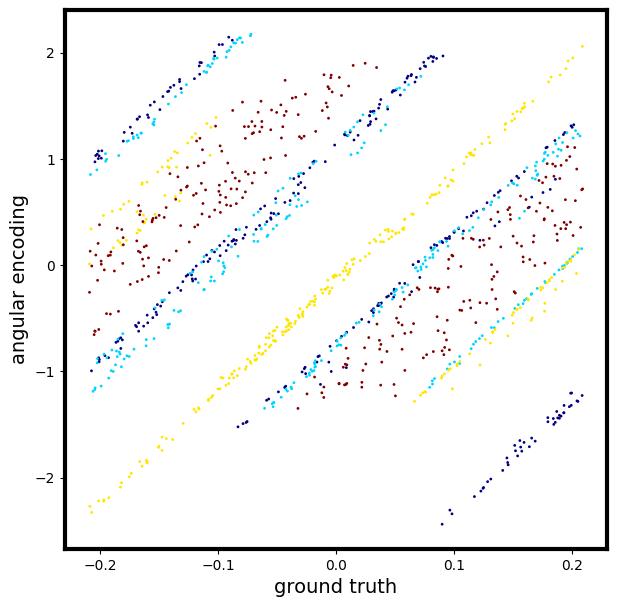

In [14]:
# Finally the plot of encoded angle vs. ground truth rotation applied to the images.
# The points are colored using the suit of the images.
# This is defined only for the rVAE configuration

fig, ax = plt.subplots(figsize = (7,7))
ax.scatter(torch.deg2rad(angles_all1), z_mean1[:,0], c = labels_all0, s =1, cmap = 'jet')
ax.set_xlabel("ground truth", fontsize=14)
ax.set_ylabel("angular encoding", fontsize=14)


This notebook illustartes the basic applications of rotationally invariant variational autoencoders. After three years applying it to a broad variety of problems in electron and scanning probe mciroscopy, including the strucutral imaging in ferroelectrics and graphene by STEM, analysis of EELS and 4D STEM data, and scanning probe microscopy of the ferroelectric domain patterns, we believe these tools to be exceptionally powerful method for discovering the hidden traits in data. The first step towards applying these methods will be developing the intuition as to how the latent spaces form, evolve, and how the disentanglement process works. This notebook can help with this. To take advantage of it anbd start building this intuition:

1. Run the simple VAE (no invariances) for the data sets with low disorder and explore the evolution of the latent representations and latent distributions
2. Chose the larger disorder and see how these latent spaces become more complex.
3. Turn on the rotational invariance, and see how latent distributions change
4. Go back to low-disorder cases.

You can also apply this notebook for analysis of your own data - or use any of the notebooks coming with our papers.

Finally, you can read a review on VAE applications for the cards data and real-world STEM graphene data set in https://arxiv.org/abs/2303.18236 and find the associated tutorials on GitHub https://github.com/saimani5/vae-tutorials


You may also ask a question - what about controlling disentanglement process? Can we add some other constraints - for example, ascribe physical meaning to some latent variables, add constraints on latent images, etc?

The answer is definitely - this is why represnetation learning is a super interetsing area. However, first it is vital to develop intuition working with simple VAEs. Have fun!